In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import tensorflow as tf
from skimage import transform

In [2]:
INPUT_IMAGES = "Input/"

TRAIN_LIMIT_SIZE = 15000
TEST_LIMIT_SIZE = 20000
BATCH_SIZE = 32

STEPS_SIZE = TRAIN_LIMIT_SIZE // BATCH_SIZE

RA_RANGE = (-180,180)
DEC_RANGE = (-90,90)
THETA_RANGE = (0,360)

image_shape = (512, 512,3)

COUNT = 10

def load_images(image_name):
    img = cv2.imread(image_name)
    img = transform.resize(img,image_shape)
    return img

def image_generator():
    while True:
        for i in range(0,STEPS_SIZE):
            batch_x_train = []
            for j in range(i*BATCH_SIZE,(i+1)*BATCH_SIZE):
                batch_x_train.append(load_images(INPUT_IMAGES+str(j+1)+".png"))
            yield np.array(batch_x_train), df_orientation.iloc[(i*BATCH_SIZE):((i+1) * BATCH_SIZE),:].values

In [3]:
def convert_true_values(dataset):
    dataset = dataset.copy()
    dataset[:,0] = dataset[:,0] * (RA_RANGE[1] - RA_RANGE[0]) + RA_RANGE[0]
    dataset[:,1] = dataset[:,1] * (DEC_RANGE[1] - DEC_RANGE[0]) + DEC_RANGE[0]
    dataset[:,2] = dataset[:,2] * (THETA_RANGE[1] - THETA_RANGE[0]) + THETA_RANGE[0]
    return dataset

In [4]:
# importing
df_orientation = pd.read_csv("orientation_data.csv")
df_orientation = df_orientation.drop("ID",axis = 1)
df_orientation = df_orientation.drop("FOV",axis = 1)

# minmax normalization
df_orientation["RA"] = (df_orientation.iloc[:,0] - RA_RANGE[0]) / (RA_RANGE[1] - RA_RANGE[0])
df_orientation["DEC"] = (df_orientation.iloc[:,1] - DEC_RANGE[0]) / (DEC_RANGE[1] - DEC_RANGE[0])
df_orientation["THETA"] = (df_orientation.iloc[:,2] - THETA_RANGE[0]) / (THETA_RANGE[1] - THETA_RANGE[0])
df_orientation.head()

,RA,DEC,THETA
0,0.208573,0.278189,0.759450
1,0.208573,0.278189,0.759450
2,0.653541,0.525090,0.636799
3,0.134132,0.462668,0.167021
4,0.680660,0.604051,0.447248


In [5]:
true_result = df_orientation.iloc[TRAIN_LIMIT_SIZE:TEST_LIMIT_SIZE,:].values

In [6]:
model = tf.saved_model.load('vit_model')

### Predicting test result

In [7]:
STEPS_SIZE_FOR_PREDICT = (TEST_LIMIT_SIZE - TRAIN_LIMIT_SIZE) // BATCH_SIZE

predict_result = np.empty((5000, 3))

for i in tqdm(range(0,STEPS_SIZE_FOR_PREDICT)):
    batch_x_test = []
    start_idx_loop = TRAIN_LIMIT_SIZE + i*BATCH_SIZE
    end_idx_loop = TRAIN_LIMIT_SIZE + (i+1)*BATCH_SIZE
    for j in range(start_idx_loop,end_idx_loop):
        batch_x_test.append(load_images(INPUT_IMAGES+str(j+1)+".png"))
    batch_x_test = np.array(batch_x_test,dtype = np.float32)
    
    result = model(batch_x_test)
    start_idx_arr = i*BATCH_SIZE
    end_idx_arr = (i+1)*BATCH_SIZE
    predict_result[start_idx_arr:end_idx_arr] = result    

100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [3:06:00<00:00, 71.54s/it]


In [8]:
predict_result = predict_result[:4992]

In [9]:
predict_result_2 = convert_true_values(predict_result)

In [10]:
pd.DataFrame(predict_result_2, columns = ["RA","DEC","THETA"]).to_csv("vit_predicted_values.csv",index = False)

### Loading already predicted result

In [11]:
true_result = convert_true_values(true_result[:4992])
# predict_result = convert_true_values(predict_result)

In [12]:
predict_result = pd.read_csv("vit_predicted_values.csv")
predict_result.head()

,RA,DEC,THETA
0,71.776192,19.156959,182.060881
1,149.068873,-67.547324,127.742050
2,-137.246152,-36.439515,172.682172
3,0.648494,-35.137614,148.629506
4,-37.253265,-25.094013,168.007339


In [13]:
predict_result = predict_result.iloc[:,:].values

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

dict_metrics = {
    "RA": [],
    "DEC": [],
    "THETA": []
}

for i, (key, value) in enumerate(dict_metrics.items()):
    mae = np.round(mean_absolute_error(true_result[:,i],predict_result[:,i]),decimals = 4)
    mse = np.round(mean_squared_error(true_result[:,i],predict_result[:,i]),decimals = 4)
    rmse = np.sqrt(mse)
    r2 = np.round(r2_score(true_result[:,i],predict_result[:,i]),decimals = 4)
    dict_metrics[key].extend([mae,mse,rmse,r2])

pd.DataFrame(dict_metrics,index = ["MAE","MSE","RMSE", "R2"])

,RA,DEC,THETA
MAE,57.024800,22.624400,82.848500
MSE,6268.531900,869.441800,9526.947000
RMSE,79.174061,29.486299,97.606081
R2,0.433600,0.421400,0.112500


### Visualization residuals for test

Text(0.5, 1.0, 'QQ Plot of Residuals')

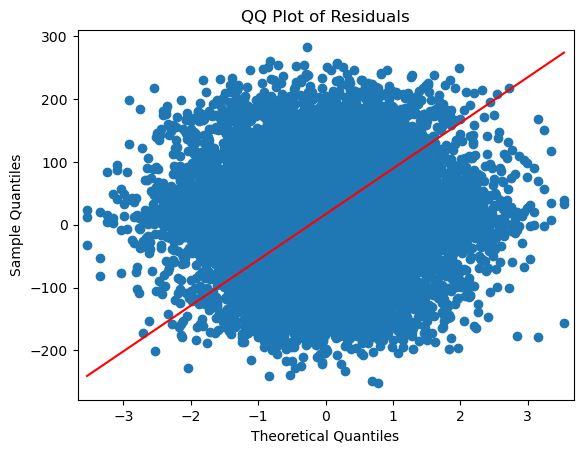

In [15]:
residuals = true_result - predict_result
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='s')
plt.title("QQ Plot of Residuals")

## COVERTING TO CLASSIFICATION

### Histogram of residuals

In [16]:
residuals_RA = true_result[:,0] - predict_result[:,0]
residuals_DEC= true_result[:,1] - predict_result[:,1]
residuals_THETA = true_result[:,2] - predict_result[:,2]

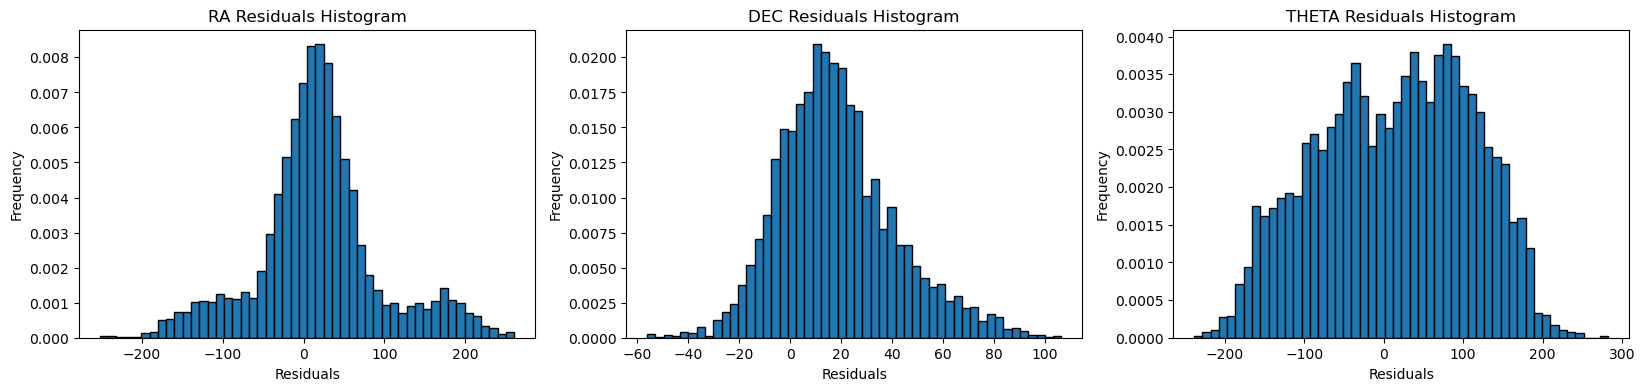

In [17]:
fig = plt.figure(figsize=(20, 4)) 
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.hist(residuals_RA, bins=50,density = True,edgecolor = "k")
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Frequency')
ax1.set_title('RA Residuals Histogram')

ax2.hist(residuals_DEC, bins=50,density = True,edgecolor = "k")
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('DEC Residuals Histogram')

ax3.hist(residuals_THETA, bins=50,density = True,edgecolor = "k")
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.set_title('THETA Residuals Histogram')
plt.show()

In [18]:
un_th  = 5

accuracy_uncer_RA = np.sum((residuals_RA >= -un_th) & (residuals_RA <= un_th)) / 4992 * 100
accuracy_uncer_DEC = np.sum((residuals_DEC >= -un_th) & (residuals_DEC <= un_th)) / 4992 * 100
accuracy_uncer_THETA = np.sum((residuals_THETA >= -un_th) & (residuals_THETA <= un_th)) / 4992 * 100

print("RA accuracy with", un_th, "degree uncertainty = ", accuracy_uncer_RA)
print("DEC accuracy with", un_th, "degree uncertainty = ", accuracy_uncer_DEC)
print("THETA accuracy with", un_th, "degree uncertainty = ", accuracy_uncer_THETA)

RA accuracy with 5 degree uncertainty =  7.371794871794872
DEC accuracy with 5 degree uncertainty =  15.144230769230768
THETA accuracy with 5 degree uncertainty =  2.864583333333333
